[Prophet Toolbox Documentation](https://facebook.github.io/prophet/docs/saturating_forecasts.html)

# Import

## Path

In [1]:
import os
import sys

p = os.path.abspath('../')
if p not in sys.path:
    print('Adding {} path to system'.format(p))
    sys.path.append(p)
    


Adding C:\Cerebral\_MarioSandBox\Python\projectPage_myOntarioCovidModelTrendAnalysis\git_projectCodes\myOntarioCovidModelTrendAnalysis path to system


The [Epidemiological Data from the COVID-19 Outbreak in Canada](https://github.com/ishaberry/Covid19Canada) located in github.



In [2]:
import plotly# Complete Database
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Modules

In [3]:
from myFunctions.covid import covid as cvd
import myFunctions.myVis as myVis

# SIR Models
import myFunctions.mySIR as mySIRModel
import myFunctions.mySIRM as mySIRMModel

# SIGR Models
import myFunctions.mySIGR as mySIGRModel
import myFunctions.mySIGRM as mySIGRMModel

# SDIR Models
import myFunctions.mySDIR as mySDIRModel
import myFunctions.mySDIRM as mySDIRMModel

#SAIR Models
import myFunctions.mySAIR as mySAIRModel
import myFunctions.mySAIRM as mySAIRMModel

In [4]:
import pandas as pd
import numpy as np

In [5]:
from utilities.EpiModel import *
import utilities.PDEparams as pde
from scipy.integrate import odeint

In [6]:
from scipy.integrate import solve_ivp
import optuna
optuna.logging.disable_default_handler()
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import timedelta

# Modeling Functions

In [14]:
def getPop(province='Ontario',p='C:\Cerebral\_MarioSandBox\Python\projectPage_myOntarioCovidModelTrendAnalysis\git_projectCodes\myOntarioCovidModelTrendAnalysis'):
    provinceDataPopFile = '\data\provincePop.csv'
    popData = pd.read_csv(p + provinceDataPopFile)
    popData = popData.set_index('province')    
    return popData.loc[province].population

# Get Data

In [8]:
covidObject = cvd(cached=True)

Getting COVID data


In [9]:
provToAnalyze = 'Ontario'
covidObject.getProcessedData(provToAnalyze)

In [10]:
# convert dictionary into dataframe
dfData = pd.DataFrame.from_dict(covidObject.dataProcess)
# convert date col to datetime pandas series
dfData['date'] = pd.to_datetime(dfData['date'])
# convert index to dates
dfData = dfData.set_index('date')

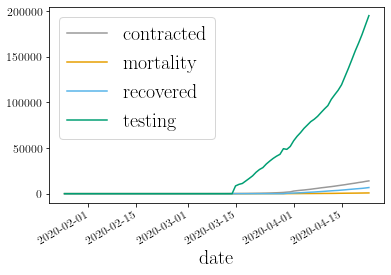

In [11]:
dfData.plot()

In [12]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-19,11539,602,5209,156097
2020-04-20,12214,651,5515,164840
2020-04-21,12706,697,5806,174170
2020-04-22,13418,757,6221,184531
2020-04-23,13996,798,6680,194745


In [15]:
provPop = getPop('Ontario')

# Trend Analysis

### Contracted

From the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-05 (25)    | 2020-03-20 (40)  |
| 2     | 2020-03-20 (40)    | 2020-04-04 (55)  |
| 3     | 2020-04-04 (55)    | today (:)        |

In [16]:
phase = [1,2,3]
phaseStart = [25,40,55]
phaseEnd = [40,55,len(dfData)]

critPhaseCases = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseCases.append(dictPhase)

### Deaths

Similar to the number of cases graph from the above critical points we see that there are 3 phases.

| Phase | Start Date (index) | End Date (index) |
|-------|--------------------|------------------|
| 1     | 2020-03-18 (38)    | 2020-03-28 (48)  |
| 2     | 2020-03-28 (48)    | 2020-04-06 (57)  |
| 3     | 2020-04-06 (57)    | today (:)        |

In [17]:
phaseStart = [38,48,57]
phaseEnd = [48,57,len(dfData)]

critPhaseDeath = []

for p,ps,pe in zip(phase,phaseStart,phaseEnd):
    dictPhase = {
        'phase':p,
        'phaseStart':ps,
        'phaseEnd':pe}
    critPhaseDeath.append(dictPhase)

# Modeling SIRM

In [18]:
critPhaseCases

[{'phase': 1, 'phaseStart': 25, 'phaseEnd': 40},
 {'phase': 2, 'phaseStart': 40, 'phaseEnd': 55},
 {'phase': 3, 'phaseStart': 55, 'phaseEnd': 75}]

In [19]:
dfData.tail()

,contracted,mortality,recovered,testing
date,,,,
2020-04-19,11539,602,5209,156097
2020-04-20,12214,651,5515,164840
2020-04-21,12706,697,5806,174170
2020-04-22,13418,757,6221,184531
2020-04-23,13996,798,6680,194745


## Estimation

### SIGR Models



In [22]:
SIGRMModelPhases = []
for i,phase in enumerate(critPhaseCases):
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    # get initial conditions   
    if i == 0:
        initConditions = {'R':0,
                      'I':df['I'][0]}
    else:
        initConditions = {'R':SIGRMModelPhases[i-1].solution['R'][-1],
                      'I':df['I'][0]}
    
    SIGRMModelPhases.append(mySIGRMModel.sigrm(data=df,
                    initConditions=initConditions))
    
    SIGRMModelPhases[i].run()

Now analyzing phase 1
   $beta_i$  $beta_g$     $phi$   $gamma$      $mu$
0  0.456332  0.434438  0.352129  0.198564  0.247573
Now analyzing phase 2
   $beta_i$  $beta_g$     $phi$   $gamma$      $mu$
0  0.430147  0.311491  0.476448  0.128415  0.159779
Now analyzing phase 3
   $beta_i$  $beta_g$     $phi$   $gamma$     $mu$
0  0.300012  0.300032  0.183726  0.199999  0.24992


### SDIR Models

In [23]:
SDIRMModelPhases = []
for i,phase in enumerate(critPhaseCases):
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    # get initial conditions   
    if i == 0:
        initConditions = {'R':0,
                      'I':df['I'][0]}
    else:
        initConditions = {'R':SDIRMModelPhases[i-1].solution['R'][-1],
                      'I':df['I'][0]}
    
    SDIRMModelPhases.append(mySDIRMModel.sdirm(data=df,
                    initConditions=initConditions))
    
    SDIRMModelPhases[i].run()

Now analyzing phase 1
   $beta_i$     $phi$   $gamma$       $mu
0  0.639099  1.422562  0.180044  0.282307
Now analyzing phase 2
   $beta_i$     $phi$   $gamma$       $mu
0  0.321756  1.160077  0.089075  0.057209
Now analyzing phase 3
   $beta_i$     $phi$   $gamma$       $mu
0   0.56484  1.106561  0.199917  0.294247


### SAIR Models

In [24]:
SAIRMModelPhases = []
for i,phase in enumerate(critPhaseCases):
    print(f"Now analyzing phase {phase['phase']}")
    
    start = phase['phaseStart']
    fin = phase['phaseEnd']
    
    # get subData
    iData = dfData['contracted'].tolist()[start:fin]
    df = pd.DataFrame(range(len(iData)),columns=['t'])
    df['I'] = iData/provPop
    
    # get initial conditions   
    if i == 0:
        initConditions = {'R':0,
                      'I':df['I'][0]}
    else:
        initConditions = {'R':SAIRMModelPhases[i-1].solution['R'][-1],
                      'I':df['I'][0]}
    
    SAIRMModelPhases.append(mySAIRMModel.sairm(data=df,
                    initConditions=initConditions))
    
    SAIRMModelPhases[i].run()

Now analyzing phase 1
   $beta_a$  $beta_i$    $phi$   $gamma$      $mu$
0     0.454  0.582509  0.10316  0.198204  0.203594
Now analyzing phase 2
   $beta_a$  $beta_i$     $phi$   $gamma$      $mu$
0  0.393369    0.5251  0.134445  0.125782  0.219408
Now analyzing phase 3
   $beta_a$  $beta_i$     $phi$   $gamma$      $mu$
0  0.300005  0.300107  0.100038  0.199988  0.025161


## Error Comparison

Lets concatonate all the models and each of their phases so we can loop through them and create a dataframe to compare the errors

In [25]:
allModels = [SIGRMModelPhases,
             SDIRMModelPhases,
             SAIRMModelPhases]

In [26]:
SIGRMModelPhases[1].name

'SIGRM'

In [27]:
modelDict = []
for model in allModels:    
    for i, phaseModel in enumerate(model):
        tempDict={}
        tempDict['Name'] = phaseModel.name
        tempDict['Phase'] = i+1
        tempDict['Error'] = phaseModel.error
        
        modelDict.append(tempDict)

modelDF = pd.DataFrame.from_dict(modelDict)

In [28]:
phaseOne = modelDF[modelDF["Phase"]==1]
phaseOne.sort_values('Error',ascending=True)

,Name,Phase,Error
0,SIGRM,1,5.973224e-13
6,SAIRM,1,6.152723e-13
3,SDIRM,1,6.928592e-13


In [29]:
phaseTwo = modelDF[modelDF["Phase"]==2]
phaseTwo.sort_values('Error',ascending=True)

,Name,Phase,Error
7,SAIRM,2,4.828263e-11
1,SIGRM,2,4.839588e-11
4,SDIRM,2,7.594177e-11


In [30]:
phaseThree = modelDF[modelDF["Phase"]==3]
phaseThree.sort_values('Error',ascending=True)

,Name,Phase,Error
5,SDIRM,3,1.382551e-09
2,SIGRM,3,2.360095e-09
8,SAIRM,3,3.054778e-09


They are really close to each other interms of error so lets looks at the graph distributions instead

## Graphing

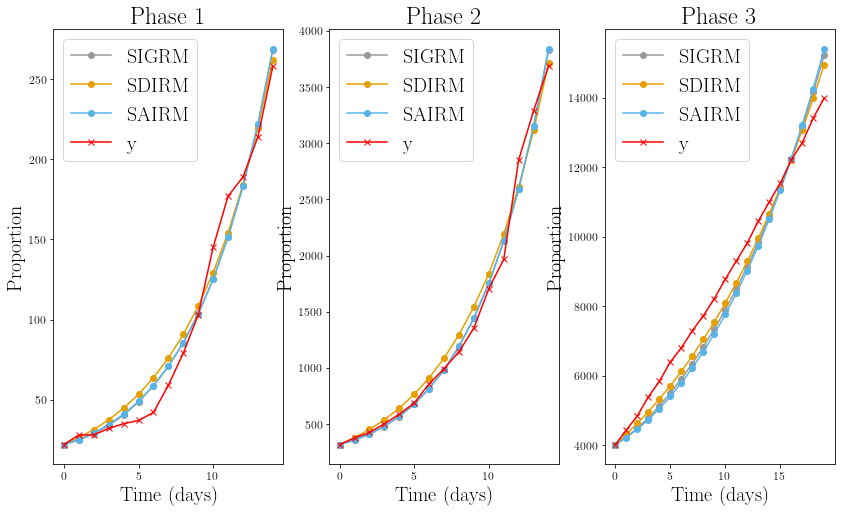

In [32]:
fig1,ax=plt.subplots(1,3,figsize=(14,8))

for i in range(3):
    for model in allModels:
        yHat = model[i].solution['I']*provPop
        ax[i].plot(range(len(yHat)),yHat,'-o',label=model[i].name)
    
    y = allModels[0][i].data['I']*provPop
    ax[i].plot(range(len(y)),y,'-x',color='r',label='y')
    ax[i].set_title(f"Phase {i+1} ")
    ax[i].set_xlabel('Time (days)')
    ax[i].set_ylabel('Proportion')
    ax[i].legend()

Based on the above phase models all seem to be very good at estimating the first two phases while the last phase  is very difficult.  I am not to sure why this is the case but there seems to be a couple that are relatively good at estimating all three.  Based on these trends we can say that maybe the best model estimation are:

- SDIRM
- SAIR
- SIGR

**Note:** Any estimation for all these models will surely over-estimate the true values but we do get a sense that these models seem to be telling the story of what is happening.

Lets plot the 3 best model estimations on the entire curve

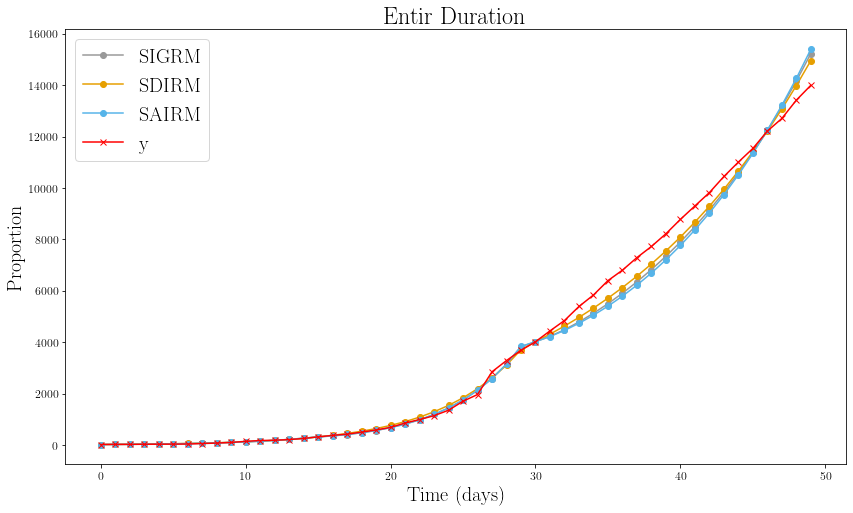

In [34]:
fig1,ax=plt.subplots(1,1,figsize=(14,8))

for model in allModels:
    yHat = []
    y = []
    for i in range(3):
        yHat.append(model[i].solution['I'])
        y.append(model[i].data['I'])

    yHat = np.concatenate(yHat)
    ax.plot(range(len(yHat)),yHat*provPop,'-o',label=model[0].name)
    y = np.concatenate(y)
   
ax.plot(range(len(y)),y*provPop,'-x',color='r',label='y')    
ax.set_title(f"Entire Duration ")
ax.set_xlabel('Time (days)')
ax.set_ylabel('Proportion')
ax.legend()
    

They are all pretty much over predicting by an alarmingly large number.  I don't trust this model rightnow so lets look at the logistic regressin analysis again and see what is going on there before continuing.  Maybe we can make these into fuctions as well so that we can run experiments and see a variety of scenarios.  I think after that, it will be my final contribution because it may take up more time than expected learning more algorithms and trying to play with them.